
<h1><center><font size="6">MobileNet Architecture Notebook</font></center></h1>



# <a id='0'>Contents</a>
- <a href='#1'>Google Colab Only</a>
    - Mounting Google Drive
    - Confirming Connection to GPU
- <a href='#2'>Importing Packages</a>  
- <a href='#3'>Preprocessing Images</a>
- <a href='#4'>Generating Datasets</a> 
    - Save Entire Dataset
    - Train-Validation-Test Split
- <a href='#5'>Preprocessing Data</a>
- <a href='#6'>Modeling</a>
    - Generating Datasets
    - Constructing and Compiling Model
    - Defining Callbacks
    - Training the Model
    - Saving the Model
    - Evaluating the Model
    - Loading the Model
    - Predicting on Holdout Set
- <a href='#7'>Making Predictions</a>      



# <a id ='1'>Google Colab Only</a>




## Mounting Google Drive (Google Only)

This notebook was run on Google Colab for GPU acceleration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Confirming connection to GPU (Google Only)

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# <a id='2'>Importing Packages</a>

<a href='#0'>Back to Top</a> 

In [29]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import ast
import pickle
import time
import glob as glob
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CategoricalCrossentropy, CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.models import model_from_json

start = dt.datetime.now()

import os

from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np

### VSCODE below

# from utils import *

# %reload_ext autoreload
# %autoreload 2

In [6]:
# Apparently you may use different seed values at each stage
seed_value = 42

# Set `PYTHONHASHSEED` environment variable at fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Set `python` built-in pseudo-random generator at fixed value
random.seed(seed_value)

# Set `numpy` pseudo-random generator at fixed value
np.random.seed(seed_value)

# Set `tensorflow` pseudo-random generator at fixed value
tf.random.set_seed(seed_value)

# Configure new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# <a id='3'>Preprocessing Images</a>

<a href='#0'>Back to Top</a> 

In [7]:
# Switching between different folders
base_dir = '/content/drive/MyDrive/Colab Notebooks/Flictionary/animals'
# base_dir = '../animals'

In [8]:
startTime = time.time()

In [9]:

classes_path = os.listdir(base_dir + '/train_simplified/')
classes_path = sorted(classes_path, key=lambda s: s.lower())
# classes_path.pop(0)
classes_path

['ant.csv',
 'bat.csv',
 'bear.csv',
 'bee.csv',
 'butterfly.csv',
 'camel.csv',
 'cat.csv',
 'cow.csv',
 'crab.csv',
 'crocodile.csv',
 'dog.csv',
 'dolphin.csv',
 'dragon.csv',
 'duck.csv',
 'elephant.csv',
 'flamingo.csv',
 'frog.csv',
 'giraffe.csv',
 'hedgehog.csv',
 'horse.csv',
 'kangaroo.csv',
 'lion.csv',
 'lobster.csv',
 'monkey.csv',
 'mosquito.csv',
 'mouse.csv',
 'octopus.csv',
 'owl.csv',
 'panda.csv',
 'parrot.csv',
 'penguin.csv',
 'pig.csv',
 'rabbit.csv',
 'raccoon.csv',
 'rhinoceros.csv',
 'scorpion.csv',
 'sea turtle.csv',
 'shark.csv',
 'sheep.csv',
 'snail.csv',
 'snake.csv',
 'spider.csv',
 'squirrel.csv',
 'swan.csv',
 'tiger.csv',
 'whale.csv',
 'zebra.csv']

In [10]:
class_dict = {x[:-4]:i for i, x in enumerate(classes_path)}
labels = {x[:-4] for i, x in enumerate(classes_path)}
n_labels = len(labels)
print("Number of labels: {}".format(n_labels))

Number of labels: 47


# <a id ='4'>Generating Datasets</a>

<a href='#0'>Back to Top</a> 

In [11]:
path = '/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/'
all_files = glob.glob(path + "/*.csv")

li = []
count = 0

for filename in all_files:
    print(filename)
    df_reduced = pd.read_csv(filename, index_col=None, header=0, nrows=50000)
    df_reduced = df_reduced[df_reduced['recognized']==True].sample(n=10000, random_state=42)
    
    count += 1
    print(df_reduced.size, count ,'/', 47)
    li.append(df_reduced)

frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.sample(n=100000, random_state=42)

del li

/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/ant.csv
60000 1 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/bat.csv
60000 2 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/bear.csv
60000 3 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/bee.csv
60000 4 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/butterfly.csv
60000 5 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/camel.csv
60000 6 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/cat.csv
60000 7 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/cow.csv
60000 8 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/crab.csv
60000 9 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/crocodile.csv
60000 10 / 47
/content/driv

In [12]:
frame['target'] = frame.word.apply(lambda x: class_dict[x])
frame.head()

,countrycode,drawing,key_id,recognized,timestamp,word,target
207110,IN,"[[[40, 32, 15, 0, 47, 46, 49, 58, 78, 61, 88, ...",5124353249247232,True,2017-01-13 18:14:17.090690,kangaroo,20
40471,TH,"[[[123, 134, 149, 157, 156, 150, 142, 123, 102...",4522455181819904,True,2017-01-31 14:48:25.209720,butterfly,4
220536,GB,"[[[170, 174, 175, 172, 168], [10, 24, 38, 40, ...",5134454345433088,True,2017-03-28 19:38:18.374820,lobster,22
239834,HU,"[[[75, 64, 52, 42, 41, 44, 58, 75, 94, 118, 15...",4739146482450432,True,2017-01-28 15:38:58.020630,monkey,23
406539,US,"[[[5, 12, 28, 46, 87, 113, 132, 150, 161, 171,...",4546748368289792,True,2017-03-17 16:40:16.127080,snake,40


## Save Entire Dataset

In [12]:
frame.to_csv('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/frame.csv', index=False)
# frame.to_csv('../data/frame.csv', index=False)

In [13]:
frame = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/frame.csv')
# frame = pd.read_csv('../data/frame.csv')

In [13]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 207110 to 229019
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   countrycode  100000 non-null  object
 1   drawing      100000 non-null  object
 2   key_id       100000 non-null  int64 
 3   recognized   100000 non-null  bool  
 4   timestamp    100000 non-null  object
 5   word         100000 non-null  object
 6   target       100000 non-null  int64 
dtypes: bool(1), int64(2), object(4)
memory usage: 5.4+ MB


## Train-Validation-Test Split

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(frame.drop(['countrycode', 'word', 'key_id', 'target', 'recognized', 'timestamp'], axis=1), 
                                                    frame['target'], 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    shuffle = True)

In [15]:
len(X_train)

80000

In [16]:
validation = pd.concat([X_valid, y_valid], axis=1)
validation.head()

,drawing,target
377922,"[[[12, 10, 0, 39, 59], [17, 53, 90, 71, 66]], ...",37
231068,"[[[88, 82, 77, 72, 72, 77, 85, 98, 114, 132, 1...",23
273817,"[[[140, 111, 89, 67, 53, 50, 61, 79, 96, 126, ...",27
193563,"[[[15, 29, 34, 52, 64, 81, 121, 127, 133, 133,...",19
310841,"[[[43, 60, 87, 110, 133, 140, 137, 124, 113, 9...",31


In [17]:
X_valid, X_test, y_valid, y_test = train_test_split(validation.drop(['target'], axis=1), 
                                                    validation['target'], 
                                                    test_size = 0.5, 
                                                    random_state = 42,
                                                    shuffle = True)

In [18]:
len(X_valid)

10000

In [19]:
size = 80

# <a id='5'>Preprocessing Data</a>

<a href='#0'>Back to Top</a> 

In [21]:
def draw_cv2(raw_strokes, size=size, lw=6):
    img = np.zeros((256, 256), np.uint8)
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, lw)
    if size != 256:
        return cv2.resize(img, (size, size))
    else:
        return img
        
def df_to_image_array(df, size=size, lw=6):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = x.reshape((len(df), size, size, 1)).astype(np.float32)
    return x

In [22]:
le = LabelEncoder()

X_tr = df_to_image_array(X_train, 80)
y_tr = le.fit_transform(y_train)
y_tr = to_categorical(y_tr)
print(X_tr.shape, y_tr.shape)

(80000, 80, 80, 1) (80000, 47)


In [70]:
X_tr[0]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)

In [67]:
X_tr.shape

(80000, 80, 80, 1)

In [68]:
y_tr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [69]:
y_tr[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [23]:
X_val = df_to_image_array(X_valid, 80)
y_val = le.transform(y_valid)
y_val = to_categorical(y_val)
print(X_val.shape, y_val.shape)

(10000, 80, 80, 1) (10000, 47)


In [24]:
X_tt = df_to_image_array(X_test, 80)
y_tt = le.transform(y_test)
y_tt = to_categorical(y_tt)
print(X_tt.shape, y_tt.shape)

(10000, 80, 80, 1) (10000, 47)


In [25]:
# For saving the pickles
with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/X_train.pickle', 'wb') as f:
    pickle.dump(X_tr, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/y_train.pickle', 'wb') as f:
    pickle.dump(y_tr, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/X_valid.pickle', 'wb') as f:
    pickle.dump(X_val, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/y_valid.pickle', 'wb') as f:
    pickle.dump(y_val, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/X_test.pickle', 'wb') as f:
    pickle.dump(X_tt, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/y_test.pickle', 'wb') as f:
    pickle.dump(y_tt, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# For loading the pickles

X_tr = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/X_train.pickle', 'rb'))
y_tr = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/y_train.pickle', 'rb'))
X_val = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/X_valid.pickle', 'rb'))
y_val = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/y_valid.pickle', 'rb'))
X_tt = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/X_test.pickle', 'rb'))
y_tt = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/y_test.pickle', 'rb'))

# <a id='6'>Modeling</a>

<a href='#0'>Back to Top</a> 

## Generating Datasets

In [33]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip = True)

datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(X_tr, y_tr, 
                                    batch_size=32,
                                    seed=42)
val_generator = datagen.flow(X_val, y_val,
                             batch_size=32,
                             seed=42)
test_generator = datagen.flow(X_tt, y_tt,
                              batch_size=1,
                              seed=42,
                              shuffle=False)                                                               

In [34]:
train_generator

## Constructing and Compiling the Model

In [ ]:
# base_model = MobileNet(input_shape=(size, size, 1), 
#                        include_top=False, 
#                        weights=None, 
#                        classes=n_labels)

# x = base_model.output
# x = Flatten()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(n_labels, activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=predictions)

# model.compile(optimizer = Adam(learning_rate = 0.002), 
#               loss='categorical_crossentropy',
#               metrics=[CategoricalCrossentropy(),
#                        CategoricalAccuracy(),
#                        TopKCategoricalAccuracy(k=3)
#                        ])
# print(model.summary())

In [35]:
model = MobileNet(input_shape = (80, 80, 1), 
                    alpha = 1., 
                    weights = None,
                    classes = 47
)
model.compile(optimizer = Adam(learning_rate = 0.002), 
              loss='categorical_crossentropy',
              metrics=[CategoricalCrossentropy(),
                       CategoricalAccuracy(),
                       TopKCategoricalAccuracy(k=3)
                       ])
print(model.summary())

Model: "mobilenet_1.00_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 40, 40, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 40, 40, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 40, 40, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 40, 40, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 40, 40, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 40, 40, 32)  

## Defining Callbacks

In [36]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.1, 
                                 patience=4,
                                 min_delta=0.005, 
                                 mode='min',  
                                 verbose=1)
filepath = '/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_mobilenet/model.{epoch:02d}-{val_loss:.2f}.hdf5'
earlyStopping = EarlyStopping(monitor = 'val_loss', 
                              verbose = 1, 
                              mode = 'min', 
                              patience = 4)
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_mobilenet/log.csv')


## Training the Model

In [37]:
histories = []
history = model.fit(generator = train_generator,
                    validation_data = val_generator,
                    steps_per_epoch = len(train_generator),
                    validation_steps = len(val_generator),
                    epochs = 30,
                    verbose = 1,
                    callbacks = [lr_reduction, mcp_save, earlyStopping, csv_logger])
histories.append(history)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
2500/2500 [==============================] - 76s 29ms/step - loss: 3.3344 - categorical_crossentropy: 3.3344 - categorical_accuracy: 0.1259 - top_k_categorical_accuracy: 0.2816 - val_loss: 3.6513 - val_categorical_crossentropy: 3.6513 - val_categorical_accuracy: 0.1527 - val_top_k_categorical_accuracy: 0.3439

Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_mobilenet/model.01-3.65.hdf5
Epoch 2/30
2500/2500 [==============================] - 70s 28ms/step - loss: 2.6613 - categorical_crossentropy: 2.6613 - categorical_accuracy: 0.2717 - top_k_categorical_accuracy: 0.4940 - val_loss: 2.3152 - val_categorical_crossentropy: 2.3152 - val_categorical_accuracy: 0.3710 - val_top_k_categorical_accuracy: 0.6011

Epoch 00002: saving model to /content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_mobilenet/model.02-2.32.hdf5
Epoch 3/30
2500/2500 [==============================] - 71s 28ms/step - loss: 2.2953 - categorical_crossentropy: 2.295

## Save Model for Flask

In [38]:
# Saving model in whole
model.save('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/model_h5.h5')

## Evaluating Model

In [39]:
# Create dataframe of the evaluation metrics in each epoch
hist_df = pd.concat([pd.DataFrame(history.history) for history in histories], sort=True)
hist_df

,categorical_accuracy,categorical_crossentropy,loss,lr,top_k_categorical_accuracy,val_categorical_accuracy,val_categorical_crossentropy,val_loss,val_top_k_categorical_accuracy
0,0.125850,3.334416,3.334416,0.0020,0.281600,0.1527,3.651288,3.651288,0.3439
1,0.271725,2.661294,2.661294,0.0020,0.494013,0.3710,2.315187,2.315187,0.6011
2,0.363788,2.295319,2.295319,0.0020,0.597375,0.4553,1.926738,1.926738,0.6864
3,0.423562,2.062446,2.062446,0.0020,0.654163,0.5073,1.713378,1.713378,0.7410
4,0.467238,1.888723,1.888723,0.0020,0.694838,0.5616,1.491134,1.491134,0.7848
5,0.497813,1.759198,1.759198,0.0020,0.725812,0.6096,1.314024,1.314024,0.8234
6,0.521213,1.674389,1.674389,0.0020,0.744075,0.6385,1.221683,1.221683,0.8424
7,0.541400,1.599379,1.599379,0.0020,0.760113,0.6396,1.214504,1.214504,0.8393
8,0.559313,1.538155,1.538155,0.0020,0.774975,0.6478,1.199607,1.199607,0.8525
9,0.572375,1.478905,1.478905,0.0020,0.786788,0.6713,1.099882,1.099882,0.8631


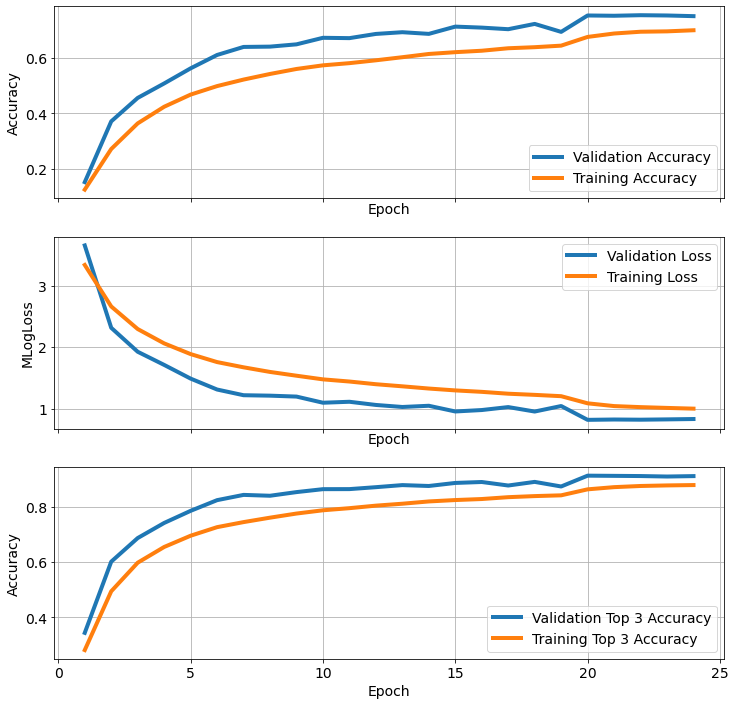

In [40]:
# Create visualizations for training vs. validation metrics
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(12, 12))
axs[0].plot(hist_df.val_categorical_accuracy, lw=4, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=4, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_loss, lw=4, label='Validation Loss')
axs[1].plot(hist_df.loss, lw=4, label='Training Loss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
axs[2].plot(hist_df.val_top_k_categorical_accuracy, lw=4, label='Validation Top 3 Accuracy')
axs[2].plot(hist_df.top_k_categorical_accuracy, lw=4, label='Training Top 3 Accuracy')
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].grid()
axs[2].legend(loc=0)
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/history3.png', dpi=300)
plt.show();

## Loading the Model

In [41]:
# load model in whole
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/model_h5.h5')

In [42]:
# test whether the two models produce same results
np.testing.assert_allclose(
    model.predict(X_tt), loaded_model.predict(X_tt)
)

## Predicting on Holdout Set

In [43]:
# get testing accuracy and loss
test_generator.reset()
score = model.evaluate(test_generator, verbose = 1)

print("Loss: " + str(score[0]))
print("Cross Categorical Entropy: " + str(score[1]))
print("Cross Categorical Accuracy: " + str(score[2]))
print("Top 3 Categorical Accuracy: " + str(score[3]))


10000/10000 [==============================] - 48s 5ms/step - loss: 0.8374 - categorical_crossentropy: 0.8374 - categorical_accuracy: 0.7535 - top_k_categorical_accuracy: 0.9063
Loss: 0.8373593688011169
Cross Categorical Entropy: 0.8373593688011169
Cross Categorical Accuracy: 0.7534999847412109
Top 3 Categorical Accuracy: 0.9063000082969666


In [44]:
test_generator.reset()
score_2 = loaded_model.evaluate(test_generator, verbose = 1)

print("Loss: " + str(score_2[0]))
print("Cross Categorical Entropy: " + str(score_2[1]))
print("Cross Categorical Accuracy: " + str(score_2[2]))
print("Top 3 Categorical Accuracy: " + str(score_2[3]))

10000/10000 [==============================] - 49s 5ms/step - loss: 0.8374 - categorical_crossentropy: 0.8374 - categorical_accuracy: 0.7535 - top_k_categorical_accuracy: 0.9063
Loss: 0.8373593688011169
Cross Categorical Entropy: 0.8373593688011169
Cross Categorical Accuracy: 0.7534999847412109
Top 3 Categorical Accuracy: 0.9063000082969666


In [74]:
scores = model.predict(X_tt, verbose=1, batch_size=1)

10000/10000 [==============================] - 48s 5ms/step


In [76]:
scores[0]

array([1.1201772e-06, 1.2401078e-04, 7.1486086e-04, 4.2530798e-04,
       2.1273759e-06, 2.1980719e-09, 1.0409608e-07, 3.6803023e-03,
       5.2113052e-07, 3.1984109e-05, 5.5990276e-06, 2.3841068e-08,
       1.6475221e-04, 1.0975339e-08, 4.7787159e-07, 2.0941899e-08,
       2.0179724e-04, 6.6406602e-07, 4.6032913e-02, 2.1937223e-04,
       1.6647247e-07, 3.4220151e-03, 1.1926699e-05, 2.6737689e-07,
       2.4173307e-05, 4.8319165e-05, 2.7742544e-07, 3.8515023e-04,
       3.7923545e-01, 2.2686390e-06, 1.1424565e-05, 2.7228813e-04,
       3.0401477e-05, 2.6889142e-01, 1.3784013e-06, 2.0321128e-03,
       3.6432024e-07, 1.7211682e-05, 6.1531473e-02, 2.2935397e-07,
       3.7346985e-07, 3.4756301e-08, 2.3194551e-01, 1.0485549e-07,
       4.5614532e-04, 3.9979528e-05, 3.3558688e-05], dtype=float32)

In [77]:
ind = (-scores[0]).argsort()[:3]

In [78]:
ind

array([28, 33, 42])

# <a id='7'>Making Predictions</a>

<a href='#0'>Back to Top</a> 

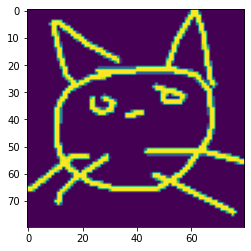

In [89]:
from random import randint
%matplotlib inline
idx = randint(0, len(X_tt))
img = X_tt[idx]
plt.imshow(img.squeeze())

In [90]:
img.squeeze().shape

(80, 80)

In [94]:
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:3]


In [95]:
pred

array([7.3060824e-04, 5.4331956e-04, 1.6999913e-03, 3.7209687e-05,
       3.2744899e-07, 2.0318005e-09, 2.0716780e-06, 5.1169768e-03,
       1.9979414e-06, 1.9142346e-05, 1.7740907e-05, 2.2186720e-08,
       2.6287101e-04, 8.0973052e-08, 3.5031334e-08, 4.2017180e-07,
       1.8598670e-04, 2.2099131e-04, 4.6936568e-02, 7.2414281e-05,
       3.4242919e-06, 3.5815770e-04, 5.8531856e-05, 7.7283335e-07,
       1.8586914e-04, 1.6316304e-04, 3.3021820e-08, 6.3005136e-04,
       3.5468543e-01, 1.7942572e-05, 9.3956642e-06, 8.1067818e-05,
       2.1087830e-05, 2.3858701e-01, 2.3765215e-07, 2.0526929e-03,
       1.9580684e-06, 1.0527016e-06, 9.0807781e-02, 8.6813384e-07,
       1.5403554e-06, 9.1204257e-08, 2.5336745e-01, 3.9791612e-07,
       3.0425293e-03, 2.9618695e-06, 6.9694150e-05], dtype=float32)

In [96]:
ind

array([28, 42, 33])

In [97]:
label_dict = {0:'ant', 1:'bat', 2:'bear', 3:'bee', 4:'butterfly', 
              5:'camel', 6:'cat', 7:'cow', 8:'crab', 9:'crocodile',
              10:'dog', 11:'dolphin', 12:'dragon', 13:'duck', 14:'elephant', 
              15:'flamingo', 16:'frog', 17:'giraffe', 18:'hedgehog', 19:'horse', 
              20:'kangaroo', 21:'lion', 22:'lobster', 23:'monkey', 24:'mosquito', 
              25:'mouse', 26:'octopus', 27:'owl', 28:'panda', 29:'parrot', 
              30:'penguin', 31:'pig', 32:'rabbit', 33:'raccoon', 34:'rhinoceros', 
              35:'scorpion', 36:'sea turtle', 37:'shark', 38:'sheep', 39:'snail', 
              40:'snake', 41:'spider', 42:'squirrel', 43:'swan', 44:'tiger', 
              45:'whale', 46:'zebra'}

In [98]:
latex = [label_dict[x] for x in ind]
print(latex)

['panda', 'squirrel', 'raccoon']


In [51]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_tt)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_tt, axis=1)
cm = confusion_matrix(y_test.astype(int), y_pred)
print(cm)

[[33  0  0 ...  0  0  0]
 [ 7  1  0 ...  1  0  0]
 [ 2  0  0 ...  0  0  0]
 ...
 [ 2  0  0 ...  0  0  0]
 [ 0  0  0 ...  2  0  0]
 [ 4  0  0 ...  0  0  0]]


In [52]:
cm_df = pd.DataFrame(cm,
                     index=['ant',
                            'bat',
                            'bear',
                            'bee',
                            'butterfly',
                            'camel',
                            'cat',
                            'cow',
                            'crab',
                            'crocodile',
                            'dog',
                            'dolphin',
                            'dragon',
                            'duck',
                            'elephant',
                            'flamingo',
                            'frog',
                            'giraffe',
                            'hedgehog',
                            'horse',
                            'kangaroo',
                            'lion',
                            'lobster',
                            'monkey',
                            'mosquito',
                            'mouse',
                            'octopus',
                            'owl',
                            'panda',
                            'parrot',
                            'penguin',
                            'pig',
                            'rabbit',
                            'raccoon',
                            'rhinoceros',
                            'scorpion',
                            'sea turtle',
                            'shark',
                            'sheep',
                            'snail',
                            'snake',
                            'spider',
                            'squirrel',
                            'swan',
                            'tiger',
                            'whale',
                            'zebra'], 
                     columns = ['ant',
                                'bat',
                                'bear',
                                'bee',
                                'butterfly',
                                'camel',
                                'cat',
                                'cow',
                                'crab',
                                'crocodile',
                                'dog',
                                'dolphin',
                                'dragon',
                                'duck',
                                'elephant',
                                'flamingo',
                                'frog',
                                'giraffe',
                                'hedgehog',
                                'horse',
                                'kangaroo',
                                'lion',
                                'lobster',
                                'monkey',
                                'mosquito',
                                'mouse',
                                'octopus',
                                'owl',
                                'panda',
                                'parrot',
                                'penguin',
                                'pig',
                                'rabbit',
                                'raccoon',
                                'rhinoceros',
                                'scorpion',
                                'sea turtle',
                                'shark',
                                'sheep',
                                'snail',
                                'snake',
                                'spider',
                                'squirrel',
                                'swan',
                                'tiger',
                                'whale',
                                'zebra'])

In [84]:
cm_df

,ant,bat,bear,bee,butterfly,camel,cat,cow,crab,crocodile,dog,dolphin,dragon,duck,elephant,flamingo,frog,giraffe,hedgehog,horse,kangaroo,lion,lobster,monkey,mosquito,mouse,octopus,owl,panda,parrot,penguin,pig,rabbit,raccoon,rhinoceros,scorpion,sea turtle,shark,sheep,snail,snake,spider,squirrel,swan,tiger,whale,zebra
ant,221,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
bat,198,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
bear,196,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
bee,185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
butterfly,213,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
camel,199,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cat,202,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cow,213,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
crab,218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
crocodile,212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<Figure size 1008x864 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix')

Text(105.0, 0.5, 'Actual Values')

Text(0.5, 87.0, 'Predicted Values')

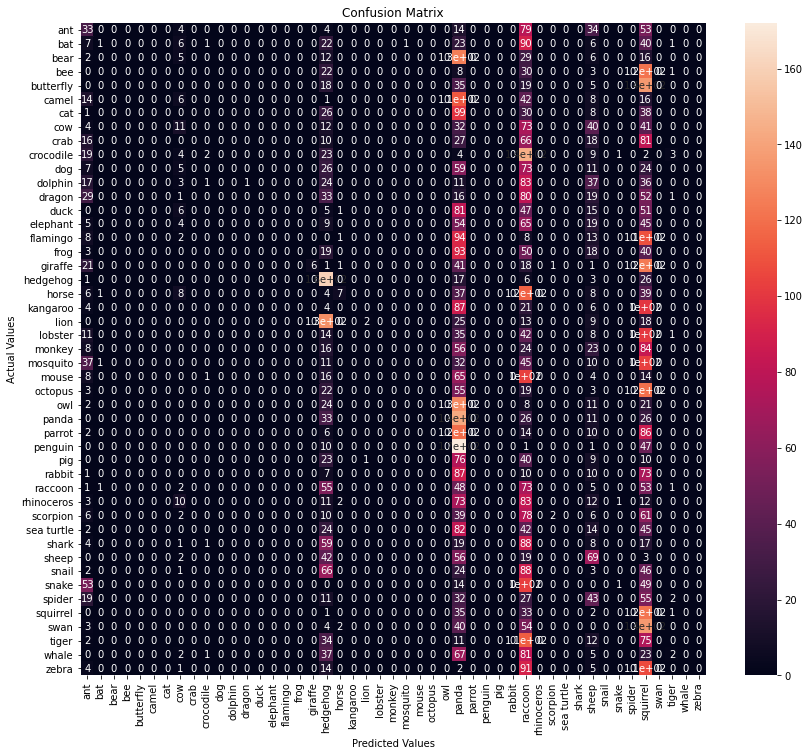

In [53]:
plt.figure(figsize=(14, 12))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<Figure size 1008x864 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f40860eaf10>,
 [Text(0, 0, 'pig'),
  Text(0, 0, 'owl'),
  Text(0, 0, 'mouse'),
  Text(0, 0, 'bee'),
  Text(0, 0, 'ant'),
  Text(0, 0, 'camel'),
  Text(0, 0, 'duck'),
  Text(0, 0, 'shark'),
  Text(0, 0, 'octopus'),
  Text(0, 0, 'sheep'),
  Text(0, 0, 'giraffe'),
  Text(0, 0, 'frog'),
  Text(0, 0, 'kangaroo'),
  Text(0, 0, 'snail'),
  Text(0, 0, 'swan'),
  Text(0, 0, 'cow'),
  Text(0, 0, 'cat'),
  Text(0, 0, 'monkey'),
  Text(0, 0, 'crab'),
  Text(0, 0, 'parrot'),
  Text(0, 0, 'raccoon'),
  Text(0, 0, 'flamingo'),
  Text(0, 0, 'crocodile'),
  Text(0, 0, 'penguin'),
  Text(0, 0, 'panda'),
  Text(0, 0, 'dolphin'),
  Text(0, 0, 'elephant'),
  Text(0, 0, 'snake'),
  Text(0, 0, 'hedgehog'),
  Text(0, 0, 'scorpion'),
  Text(0, 0, 'bat'),
  Text(0, 0, 'sea turtle'),
  Text(0, 0, 'rabbit'),
  Text(0, 0, 'rhinoceros'),
  Text(0, 0, 'butterfly'),
  Text(0, 0, 'dragon'),
  Text(0, 0, 'tiger'),
  Text(0, 0, 'horse'),
  Text(0, 0, 'mosquito'),
  Text(0, 0, 'whale'),
  T

([<matplotlib.axis.YTick at 0x7f40860a6ed0>,
 [Text(0, 0, 'pig'),
  Text(0, 0, 'owl'),
  Text(0, 0, 'mouse'),
  Text(0, 0, 'bee'),
  Text(0, 0, 'ant'),
  Text(0, 0, 'camel'),
  Text(0, 0, 'duck'),
  Text(0, 0, 'shark'),
  Text(0, 0, 'octopus'),
  Text(0, 0, 'sheep'),
  Text(0, 0, 'giraffe'),
  Text(0, 0, 'frog'),
  Text(0, 0, 'kangaroo'),
  Text(0, 0, 'snail'),
  Text(0, 0, 'swan'),
  Text(0, 0, 'cow'),
  Text(0, 0, 'cat'),
  Text(0, 0, 'monkey'),
  Text(0, 0, 'crab'),
  Text(0, 0, 'parrot'),
  Text(0, 0, 'raccoon'),
  Text(0, 0, 'flamingo'),
  Text(0, 0, 'crocodile'),
  Text(0, 0, 'penguin'),
  Text(0, 0, 'panda'),
  Text(0, 0, 'dolphin'),
  Text(0, 0, 'elephant'),
  Text(0, 0, 'snake'),
  Text(0, 0, 'hedgehog'),
  Text(0, 0, 'scorpion'),
  Text(0, 0, 'bat'),
  Text(0, 0, 'sea turtle'),
  Text(0, 0, 'rabbit'),
  Text(0, 0, 'rhinoceros'),
  Text(0, 0, 'butterfly'),
  Text(0, 0, 'dragon'),
  Text(0, 0, 'tiger'),
  Text(0, 0, 'horse'),
  Text(0, 0, 'mosquito'),
  Text(0, 0, 'whale'),
  T

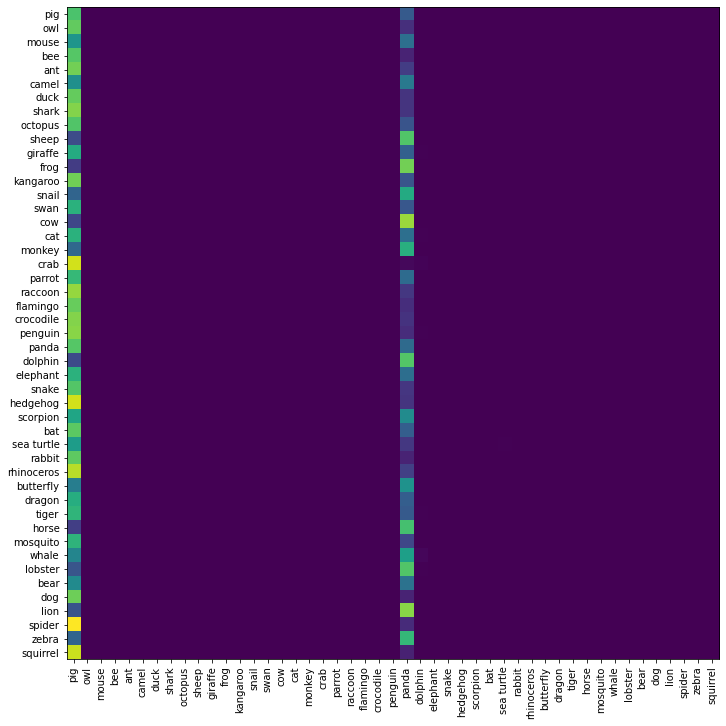

In [ ]:
plt.figure(figsize=(14, 12))
plt.imshow(cm, interpolation='nearest')
plt.xticks(np.arange(0, n_labels), labels, rotation=90)
plt.yticks(np.arange(0, n_labels), labels)

plt.show()

In [ ]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

Latest run 2021-09-13 06:08:30.195824.
Total time 5795s
